Testing 1-choice strategy
Testing 2-choice strategy
Testing (1+0.3)-choice strategy
Testing (1+0.5)-choice strategy
Testing (1+0.8)-choice strategy
Testing partial information (k=2)
Testing batched 2-choice (b='100')
Testing batched 2-choice (b='250')
Testing batched 2-choice (b='500')


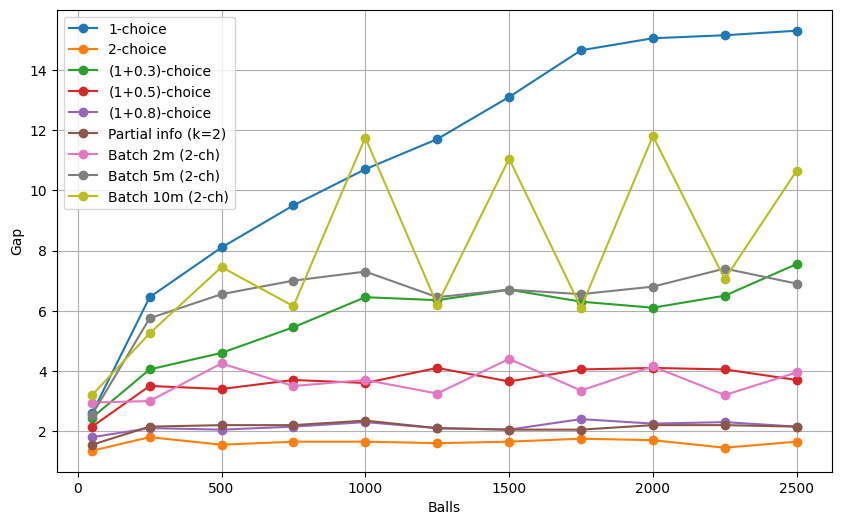

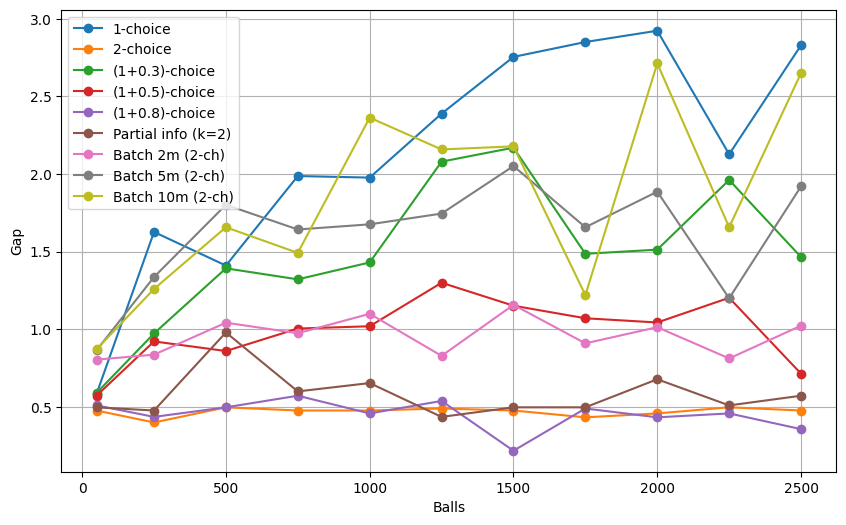

In [22]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def run_experiment(num_bins, num_balls, strategy, extra_params=None):
    bins = [0] * num_bins
    
    if extra_params is None:
        extra_params = {}
    
    beta = extra_params.get('beta', 0.5)
    k = extra_params.get('k', 0)
    batch_size = extra_params.get('batch_size', 1)
    
    balls_used = 0
    
    while balls_used < num_balls:
        this_batch = min(batch_size, num_balls - balls_used)
        if batch_size > 1 or strategy == "partial_info":
            bin_snapshot = bins.copy()
        else:
            bin_snapshot = bins        
        for i in range(this_batch):
            chosen_bin = -1
            
            
            if strategy == "one_choice":
                # Pick a random bin
                chosen_bin = random.randint(0, num_bins - 1)
                
            elif strategy == "d_choice":
                # Pick d random bins and choose the emptiest one
                random_bins = random.sample(range(num_bins), 2)
                
                min_balls = bin_snapshot[random_bins[0]]
                best_bins = [random_bins[0]]
                
                for bin_idx in random_bins[1:]:
                    if bin_snapshot[bin_idx] < min_balls:
                        min_balls = bin_snapshot[bin_idx]
                        best_bins = [bin_idx]
                    elif bin_snapshot[bin_idx] == min_balls:
                        best_bins.append(bin_idx)
                
                chosen_bin = random.choice(best_bins)
                
            elif strategy == "one_plus_beta":
                if random.random() < beta:
                    random_bins = random.sample(range(num_bins), 2)
                    
                    if bin_snapshot[random_bins[0]] < bin_snapshot[random_bins[1]]:
                        chosen_bin = random_bins[0]
                    elif bin_snapshot[random_bins[1]] < bin_snapshot[random_bins[0]]:
                        chosen_bin = random_bins[1]
                    else:
                        chosen_bin = random.choice(random_bins)
                else:
                    chosen_bin = random.randint(0, num_bins - 1)
                    
            elif strategy == "partial_info":
                random_bins = random.sample(range(num_bins), 2)
                Q3_load = np.percentile(bin_snapshot, 75)
                median = np.median(bin_snapshot)
                Q1_load = np.percentile(bin_snapshot, 25) 
                above_median = [c for c in random_bins if bin_snapshot[c] > median]
                below_median = [c for c in random_bins if bin_snapshot[c] <= median]

                if above_median and below_median:
                    chosen_bin = below_median[0]
                                    
                elif below_median:
                    if k == 1:
                        chosen_bin = random.choice(random_bins)
                    else:
                        in_top_75 = [c for c in below_median if bin_snapshot[c] >= Q1_load]
                        not_in_top_75 = [c for c in below_median if bin_snapshot[c] < Q1_load]
                        
                        if in_top_75 and not_in_top_75:
                            chosen_bin = not_in_top_75[0]
                        else:
                            chosen_bin = random.choice(below_median)
                            
                else:
                    if k == 1:
                        chosen_bin = random.choice(random_bins)
                    else:
                        in_top_25 = [c for c in above_median if bin_snapshot[c] >= Q3_load]
                        not_in_top_25 = [c for c in above_median if bin_snapshot[c] < Q3_load]

                        if in_top_25 and not_in_top_25:
                            chosen_bin = not_in_top_25[0]
                        else:
                            chosen_bin = random.choice(above_median)
                            
            else:
                # Unknown strategy, just pick random
                chosen_bin = random.randint(0, num_bins - 1)
            
            bins[chosen_bin] += 1
            balls_used += 1
    
    # Calculate the gap: max load - average load
    max_load = max(bins)
    avg_load = num_balls / num_bins
    gap = max_load - avg_load
    
    return gap



#Mutliple trials
def run_multiple_trials(num_bins, num_balls_list, strategy, num_trials=10, extra_params=None):
    avg_gaps = []
    std_gaps = []
    
    for num_balls in num_balls_list:
        #gap is the difference between max load and average load
        gaps = []
        for trial in range(num_trials):
            gap = run_experiment(num_bins, num_balls, strategy, extra_params) 
            gaps.append(gap)
        
        average_gap = sum(gaps) / len(gaps)
        variance = sum((x - average_gap) ** 2 for x in gaps) / len(gaps)
        std_dev = variance ** 0.5
        
        avg_gaps.append(average_gap)
        std_gaps.append(std_dev)
    
    return avg_gaps, std_gaps

#plotting
def make_plot(results, m):
    plt.figure(figsize=(10, 6))
    
    for name, x, y, _ in results:
        plt.plot(x, y, label=name, marker='o')
    
    plt.xlabel('Balls')
    plt.ylabel('Gap')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    
    for name, x, y, _ in results:
        plt.plot(x, _, label=name, marker='o')
    
    plt.xlabel('Balls')
    plt.ylabel('Gap')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main 
    
num_bins = 50
num_trials = 20
    
n_values = [50, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]
all_results = []
    
# One-choice (baseline)
print("Testing 1-choice strategy")
avg_gaps, std_gaps = run_multiple_trials(num_bins, n_values, "one_choice", num_trials)
all_results.append(("1-choice", n_values, avg_gaps, std_gaps))
    
    # Two-choice
print("Testing 2-choice strategy")
avg_gaps, std_gaps = run_multiple_trials(num_bins, n_values, "d_choice", num_trials)
all_results.append(("2-choice", n_values, avg_gaps, std_gaps))
    
        # (1+beta) strategies
for beta in [0.3, 0.5, 0.8] :
    print(f"Testing (1+{beta})-choice strategy")
    avg_gaps, std_gaps = run_multiple_trials(num_bins, n_values, "one_plus_beta", num_trials, {'beta': beta})
    all_results.append((f"(1+{beta})-choice", n_values, avg_gaps, std_gaps))
    
# Partial information
print("Testing partial information (k=2)")
avg_gaps, std_gaps = run_multiple_trials(num_bins, n_values, "partial_info", num_trials)
all_results.append(("Partial info (k=2)", n_values, avg_gaps, std_gaps))
    
    # Batched 2-choice
batch_size = [100, 250, 500]
for d in batch_size:
    print(f"Testing batched 2-choice (b='{d}')")
    avg_gaps, std_gaps = run_multiple_trials(num_bins, n_values, "d_choice", num_trials, {'batch_size': d})
    all_results.append((f"Batch {d//num_bins}m (2-ch)", n_values, avg_gaps, std_gaps))

make_plot(all_results, num_bins)

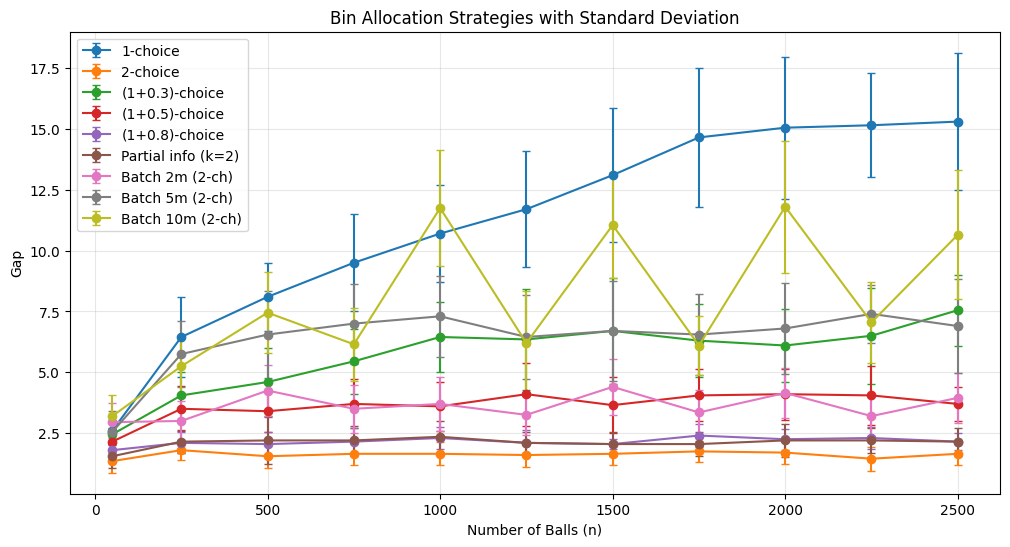

In [24]:
df

plt.figure(figsize=(12, 6))
for col in df.columns:
    if col.endswith('_gap') and col != 'n':
        strategy = col.replace('_gap', '')
        std_col = strategy + '_std'
        
        plt.errorbar(df['n'], df[col], yerr=df[std_col], 
                    label=strategy, marker='o', capsize=3)

plt.xlabel('Number of Balls (n)')
plt.ylabel('Gap')
plt.title('Bin Allocation Strategies with Standard Deviation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

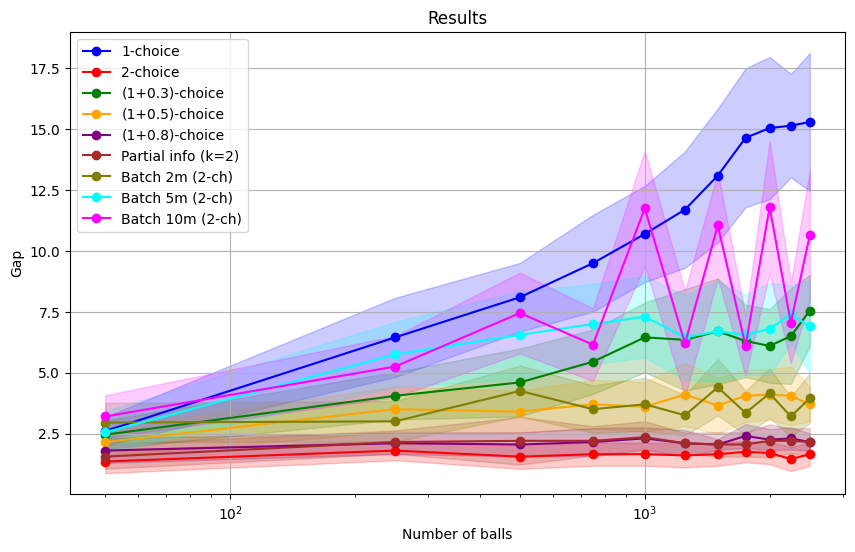

In [25]:
def make_plot(results, m):
    plt.figure(figsize=(10, 6))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'olive', 'cyan', 'magenta']
    
    for i, (name, x, y_avg, y_std) in enumerate(results):
        c = colors[i % len(colors)]
        plt.plot(x, y_avg, label=name, color=c, marker='o')
        
        low = [a - s for a, s in zip(y_avg, y_std)]
        high = [a + s for a, s in zip(y_avg, y_std)]
        plt.fill_between(x, low, high, alpha=0.2, color=c)
    
    plt.xlabel('Number of balls')
    plt.ylabel('Gap')
    plt.title('Results')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')
    plt.show()

make_plot(all_results, num_bins)


In [23]:
df_data = {'n': all_results[0][1]}

for strategy, _, gaps, stds in all_results:
    df_data[f"{strategy}_gap"] = gaps
    df_data[f"{strategy}_std"] = stds

df = pd.DataFrame(df_data)
print(df)

       n  1-choice_gap  1-choice_std  2-choice_gap  2-choice_std  \
0     50          2.60      0.583095          1.35      0.476970   
1    250          6.45      1.627114          1.80      0.400000   
2    500          8.10      1.410674          1.55      0.497494   
3    750          9.50      1.987461          1.65      0.476970   
4   1000         10.70      1.977372          1.65      0.476970   
5   1250         11.70      2.389561          1.60      0.489898   
6   1500         13.10      2.754995          1.65      0.476970   
7   1750         14.65      2.850877          1.75      0.433013   
8   2000         15.05      2.923611          1.70      0.458258   
9   2250         15.15      2.127792          1.45      0.497494   
10  2500         15.30      2.830194          1.65      0.476970   

    (1+0.3)-choice_gap  (1+0.3)-choice_std  (1+0.5)-choice_gap  \
0                 2.45            0.589491                2.15   
1                 4.05            0.973396         